# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [ ]:
#!pip install datasets

Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [2]:
# Чтобы в дальнейшем пользоваться токенизатором.
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\STEPANJUK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [4]:
""" Загрузим датасет 'ag_news':

ag_news — это популярный датасет для задачи классификации новостей. Он содержит новостные статьи, 
каждая из которых относится к одной из четырёх категорий:
    0 — World (Мировые новости)
    1 — Sports (Спорт)
    2 — Business (Бизнес)
    3 — Science/Technology (Наука и технологии)
"""
dataset = datasets.load_dataset('ag_news')

In [5]:
print('Text:')
print(dataset['train'][0]['text'])
print('Label:')
print(dataset['train'][0]['label'])

Text:
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Label:
2


Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [6]:
# Считаем частоту вхождения слов чтобы составить словарь.
words = Counter()

# Каждый отзыв в датасете
for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    # Считаем частоту вхождений для каждого слова во все статьи'ag_news'
    for word in word_tokenize(prccessed_text):
        words[word] += 1

# Составим словарь vocab.
# Добавим служебные слова:
    #'<unk>'- неизвестные слова, 
    #'<bos>' - начало последовательности, 
    #'<eos>' - конец последовательности, 
    #'<pad>' - для обьеденения последовательностей. 
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
# Пороговая частота встречаемости слова в тренировочных данных для добавления в словарь.
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

# Два словаря ( слово в индекс ) и (индекс в слово)
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [7]:
# Dataset хранит в себе примеры для передачи в Dataloader.
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        #'<unk>'- неизвестные слова 
        self.unk_id = word2ind['<unk>']
        #'<bos>' - начало последовательности
        self.bos_id = word2ind['<bos>']
        #'<eos>' - конец последовательности
        self.eos_id = word2ind['<eos>']
        #'<pad>' - для обьеденения последовательностей
        self.pad_id = word2ind['<pad>']

    # по индексу получаем пример из датасета.
    def __getitem__(self, idx: int) -> List[int]:
        # Приводим к нижнему регистру и убираем пунктуацию.
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        # Добавляем ID токена '<bos>' - начало последовательности
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            # word_tokenize(processed_text) - разбиваем текст на отдельные слова (токены).
            # for word in word_tokenize(processed_text) - проходим через каждое слово (токен) в тексте
            # word2ind.get(word, self.unk_id) - получить индекс слова в словаре
            # Если в отзыве нет слова из словаря возвращаем "self.unk_id", если есть, то ID слова.
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        # Добавляем ID токена '<eos>' - конец последовательности
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


# Собираем последовательности(текста) разных длин в один бач.
# Функция принимает на вход батч из датадлоадера. 
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    # Длинны всех текстов в баче.
    seq_lens = [len(x['text']) for x in input_batch]
    # Ограничение максимальной длинны последовательности(что меньше "max_len=256" или "max(seq_lens)"?).
    max_seq_len = min(max(seq_lens), max_len)

    # Формирируем новый батч последовательности.
    new_batch = []
    # Проходи через каждую новость в батче.
    for sequence in input_batch:
        # Ограничиваем длинну последовательности.
        sequence['text'] = sequence['text'][:max_seq_len]
        # Можно добавить pad_id ('<pad>' - для обьеденения последовательностей и заполнения пустоты). 
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)
        # Добавляем к новому батчу ограниченную по длинне последовательность с pad_id по краям.
        new_batch.append(sequence['text'])

    # Конвертируем последовательность в тензор и загружаем на девайс.
    sequences = torch.LongTensor(new_batch).to(device)
    # labels каждому отзыву соответствует метка: 0 — World (Мировые новости), 1 — Sports (Спорт),
    # 2 — Business (Бизнес), 3 — Science/Technology (Наука и технологии)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [8]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [9]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Функция для обучения модели

In [10]:
def train(
        model: nn.Module,         # Модель
        criterion: nn.Module,     # Функция потерь
        optimizer: torch.optim.Optimizer, # оптимизатор 
        num_epochs: int,          # Кол-во эпох
        train_loader: DataLoader, # Тренировочные данные
        val_loader: DataLoader    # Валидационные данные
        #aggregation_type: 'mean' # Тип агрегации скрытых слоёв
        ) -> [List[float], List[float]]:
    
    eval_steps = len(train_loader) // 2
    losses = []
    acc = []

    for epoch in range(num_epochs):
        epoch_losses = []
        model.train()
        
        for i, batch in enumerate(tqdm(train_loader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))


    return losses, acc

## Функции для построения графиков

In [11]:
def losses_plot(losses):
    plt.plot(np.arange(len(losses)), losses, color='red', label='losses')
    
    plt.title('Losses')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

In [12]:
def accuracies_plot(accur):
    plt.plot(np.arange(len(accur[1:])), accur[1:], color='blue', label='acc')
    print(f"Лучшая accuracy для подхода: {(max(accur) * 100):.2f}")
    
    plt.title('Accuracy')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

In [13]:
class Basic_RNN_Language_Model(nn.Module):
    
    def __init__(self,
                 hidden_dim: int,          # скрытая размерность
                 vocab_size: int,          # Размер словаря
                 num_classes: int = 4,     # Кол-во классов для предсказания
                 num_rnn_layers: int = 1,  # Кол-во рекуррентных слоев модели. 
                 p_dropout: float=0.1,     # Вероятность обнуления для каждого элемента входного тензора слоя nn.Dropout
                 aggregation_type: str = 'max'): # Тип агрегации скрытых слоёв
        
        super().__init__()
        # Матрица эмбедингов, хранит в каждой строке вектор слова.
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        
        # Рекуррентный блок.
        # На входе вектор слова (входная скрытая размерность), на выходе скрытый слой (выходная скрытая размерность), 
        # а так же кол-во рекуррентных слоев модели. 
        self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers=num_rnn_layers, batch_first=True)
        
        # Линейный слой().
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        
        # Предсказывающий линейный слой.
        self.projection = nn.Linear(hidden_dim, num_classes)
        
        # Функция активации.
        self.non_lin = nn.Tanh()
        
        # Dropout - методом регуляризации и предотвращения коадаптации нейронов 
        self.dropout = nn.Dropout(p = p_dropout)
        
        # Тип агрегации скрытых слоёв
        self.aggregation_type = aggregation_type

    # Получаем входной батч.
    def forward(self, input_batch) -> torch.Tensor:
        # Эмбединги для входного батча
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [14]:
model_Basic_RNN = Basic_RNN_Language_Model(
                                        hidden_dim=512, 
                                        vocab_size=len(vocab), 
                                        num_classes = 4,
                                        aggregation_type='max').to(device)

criterion_Basic_RNN = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer_Basic_RNN = torch.optim.Adam(model_Basic_RNN.parameters())

In [15]:
epochs = 10

losses_Basic_RNN, accuracies_Basic_RNN = train( model = model_Basic_RNN,         # Модель
                                                criterion = criterion_Basic_RNN,     # Функция потерь
                                                optimizer = optimizer_Basic_RNN, # оптимизатор 
                                                num_epochs = epochs,          # Кол-во эпох
                                                train_loader = train_dataloader, # Тренировочные данные
                                                val_loader = eval_dataloader    # Валидационные данные
                                                )

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

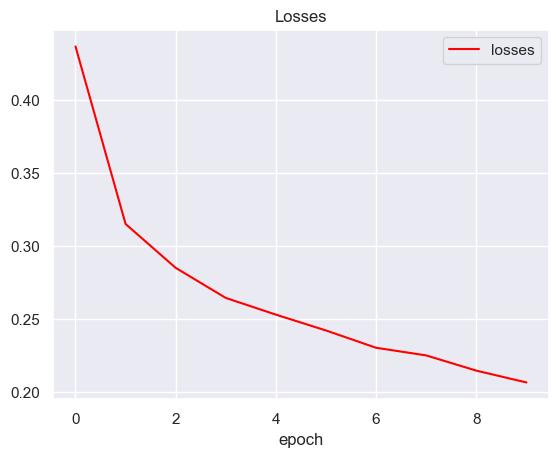

In [16]:
losses_plot(losses_Basic_RNN)

Лучшая accuracy для подхода: 90.54


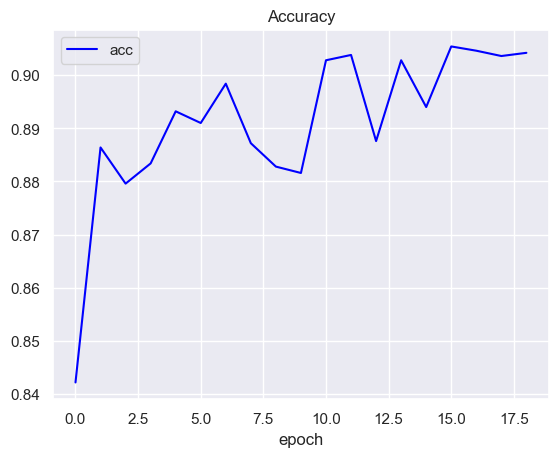

In [17]:
accuracies_plot(accuracies_Basic_RNN)

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.

#### GRU:

In [18]:
class GRU_Language_Model(Basic_RNN_Language_Model):
    
    def __init__(self,
                 hidden_dim: int,          # скрытая размерность
                 vocab_size: int,          # Размер словаря
                 num_classes: int = 4,     # Кол-во классов для предсказания
                 num_rnn_layers: int = 1,  # Кол-во рекуррентных слоев модели. 
                 p_dropout: float=0.1,     # Вероятность обнуления для каждого элемента входного тензора слоя nn.Dropout
                 aggregation_type: str = 'max'): # Тип агрегации скрытых слоёв
        
        super().__init__(
            hidden_dim,
            vocab_size,
            num_classes,
            num_rnn_layers,
            p_dropout,
            aggregation_type
        )

        # Рекуррентный блок.
        # На входе вектор слова (входная скрытая размерность), на выходе скрытый слой (выходная скрытая размерность), 
        # а так же кол-во рекуррентных слоев модели. 
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=num_rnn_layers, batch_first=True)



In [19]:
model_GRU = GRU_Language_Model(
                                hidden_dim=512, 
                                vocab_size=len(vocab), 
                                num_classes = 4,
                                aggregation_type='max').to(device)

criterion_GRU = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer_GRU = torch.optim.Adam(model_GRU.parameters())

In [20]:
epochs = 10

losses_GRU, accuracies_GRU = train( model = model_GRU,         # Модель
                                    criterion = criterion_GRU,     # Функция потерь
                                    optimizer = optimizer_GRU, # оптимизатор 
                                    num_epochs = epochs,          # Кол-во эпох
                                    train_loader = train_dataloader, # Тренировочные данные
                                    val_loader = eval_dataloader    # Валидационные данные
                                    )

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

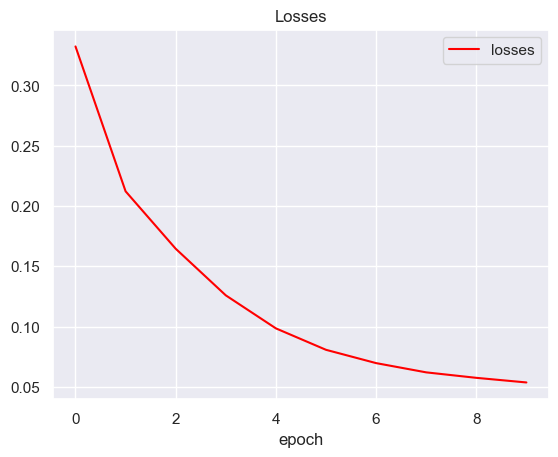

In [21]:
losses_plot(losses_GRU)

Лучшая accuracy для подхода: 91.64


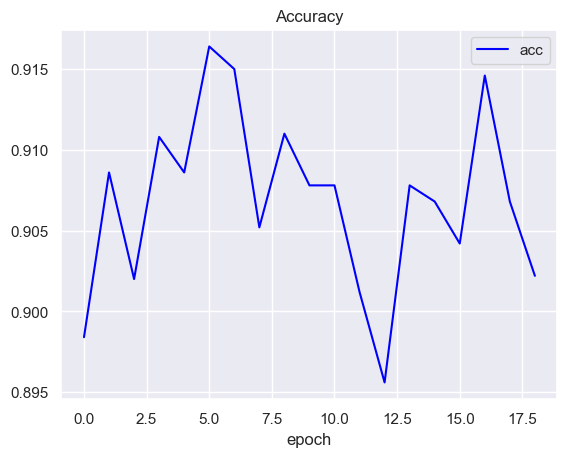

In [22]:
accuracies_plot(accuracies_GRU)

#### LSTM:

In [23]:
class LSTM_Language_Model(Basic_RNN_Language_Model):
    
    def __init__(self,
                 hidden_dim: int,          # скрытая размерность
                 vocab_size: int,          # Размер словаря
                 num_classes: int = 4,     # Кол-во классов для предсказания
                 num_rnn_layers: int = 1,  # Кол-во рекуррентных слоев модели. 
                 p_dropout: float=0.1,     # Вероятность обнуления для каждого элемента входного тензора слоя nn.Dropout
                 aggregation_type: str = 'max'): # Тип агрегации скрытых слоёв
        
        super().__init__(
            hidden_dim,
            vocab_size,
            num_classes,
            num_rnn_layers,
            p_dropout,
            aggregation_type
        )

        # Рекуррентный блок.
        # На входе вектор слова (входная скрытая размерность), на выходе скрытый слой (выходная скрытая размерность), 
        # а так же кол-во рекуррентных слоев модели. 
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_rnn_layers, batch_first=True)

In [24]:
model_LSTM = LSTM_Language_Model(
                                hidden_dim=512, 
                                vocab_size=len(vocab), 
                                num_classes = 4,
                                aggregation_type='max').to(device)

criterion_LSTM = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer_LSTM = torch.optim.Adam(model_LSTM.parameters())

In [25]:
epochs = 10

losses_LSTM, accuracies_LSTM = train( model = model_LSTM,         # Модель
                                    criterion = criterion_LSTM,     # Функция потерь
                                    optimizer = optimizer_LSTM, # оптимизатор 
                                    num_epochs = epochs,          # Кол-во эпох
                                    train_loader = train_dataloader, # Тренировочные данные
                                    val_loader = eval_dataloader    # Валидационные данные
                                    )

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

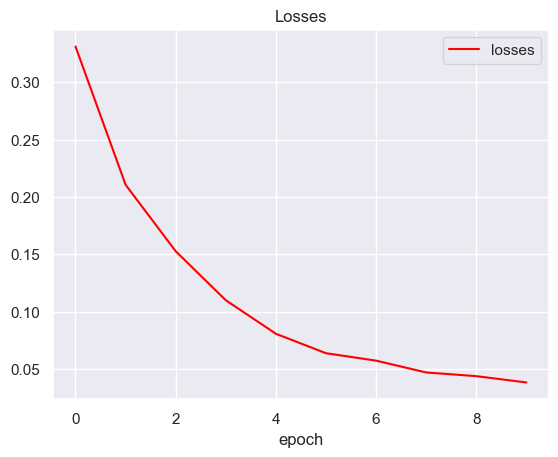

In [26]:
losses_plot(losses_LSTM)

Лучшая accuracy для подхода: 91.46


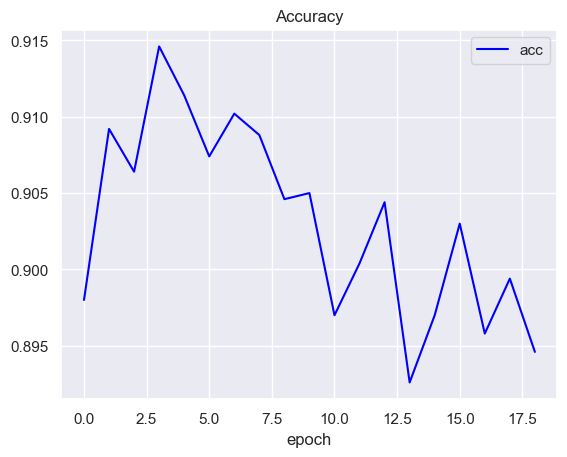

In [27]:
accuracies_plot(accuracies_LSTM)

* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.


In [28]:
model_GRU_multi_layer = GRU_Language_Model(
                                hidden_dim=512, 
                                vocab_size=len(vocab), 
                                num_classes = 4,
                                num_rnn_layers = 5, 
                                aggregation_type='max').to(device)

criterion_GRU_multi_layer = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer_GRU_multi_layer = torch.optim.Adam(model_GRU_multi_layer.parameters())

In [29]:
epochs = 10

losses_GRU_multi_layer, accuracies_GRU_multi_layer = train( model = model_GRU_multi_layer,         # Модель
                                                            criterion = criterion_GRU_multi_layer,     # Функция потерь
                                                            optimizer = optimizer_GRU_multi_layer, # оптимизатор 
                                                            num_epochs = epochs,          # Кол-во эпох
                                                            train_loader = train_dataloader, # Тренировочные данные
                                                            val_loader = eval_dataloader    # Валидационные данные
                                                            )

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

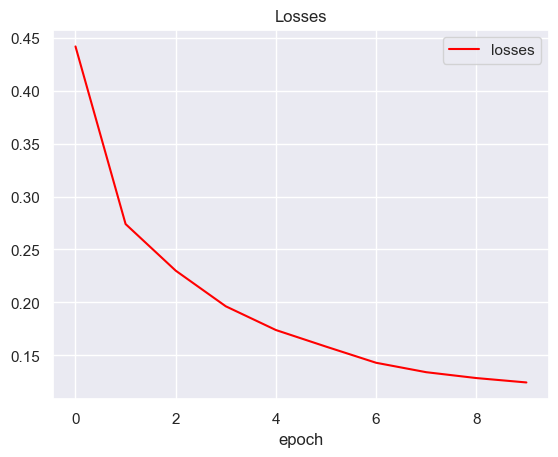

In [30]:
losses_plot(losses_GRU_multi_layer)

Лучшая accuracy для подхода: 90.88


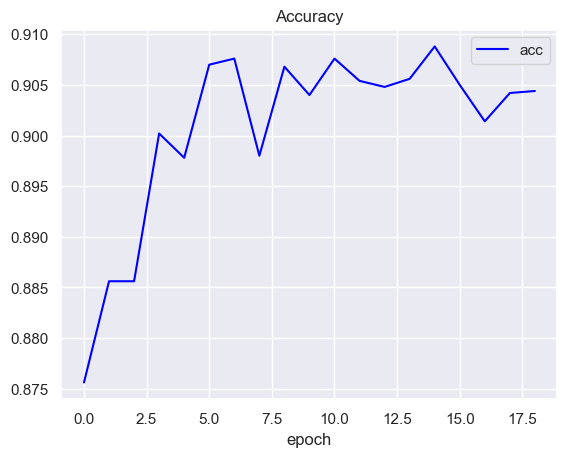

In [31]:
accuracies_plot(accuracies_GRU_multi_layer)

* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.

In [32]:
class RNN_Language_Model_concat_agg_and_last(Basic_RNN_Language_Model):
    
    def __init__(self,
                 hidden_dim: int,          # скрытая размерность
                 vocab_size: int,          # Размер словаря
                 num_classes: int = 4,     # Кол-во классов для предсказания
                 num_rnn_layers: int = 1,  # Кол-во рекуррентных слоев модели. 
                 p_dropout: float=0.1,     # Вероятность обнуления для каждого элемента входного тензора слоя nn.Dropout
                 aggregation_type: str = 'max'): # Тип агрегации скрытых слоёв
        
        super().__init__(
            hidden_dim,
            vocab_size,
            num_classes,
            num_rnn_layers,
            p_dropout,
            aggregation_type
        )

    
        # Линейный слой().
        self.linear = nn.Linear(2 * hidden_dim, hidden_dim)
    
    # Получаем входной батч.
    def forward(self, input_batch) -> torch.Tensor:
        # Эмбединги для входного батча
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        last_output = output [:, -1]  # [batch_size, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
            
            output = torch.cat((output, last_output), dim=1)  # [batch_size, 2 * hidden_dim]
            
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
            
            output = torch.cat((output, last_output), dim=1)  # [batch_size, 2 * hidden_dim]
            
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [33]:
model_RNN_concat_agg_and_last = RNN_Language_Model_concat_agg_and_last(
                                                                    hidden_dim=512, 
                                                                    vocab_size=len(vocab), 
                                                                    num_classes = 4,
                                                                    aggregation_type='max').to(device)

criterion_RNN_concat_agg_and_last = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer_RNN_concat_agg_and_last = torch.optim.Adam(model_RNN_concat_agg_and_last.parameters())

In [34]:
epochs = 10

losses_RNN_concat_agg_and_last, accuracies_RNN_concat_agg_and_last = train( model = model_RNN_concat_agg_and_last,    # Модель
                                                criterion = criterion_RNN_concat_agg_and_last,     # Функция потерь
                                                optimizer = optimizer_RNN_concat_agg_and_last, # оптимизатор 
                                                num_epochs = epochs,          # Кол-во эпох
                                                train_loader = train_dataloader, # Тренировочные данные
                                                val_loader = eval_dataloader    # Валидационные данные
                                                )

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

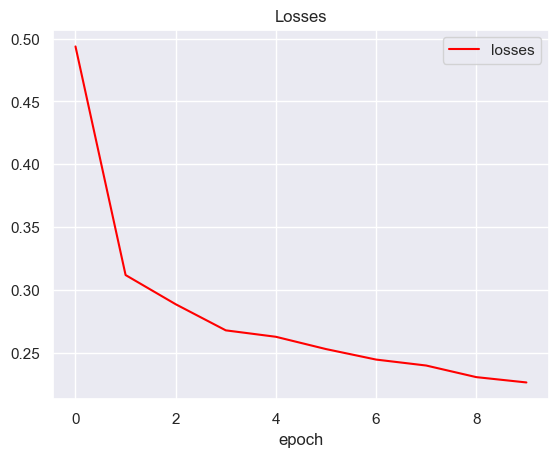

In [35]:
losses_plot(losses_RNN_concat_agg_and_last)

Лучшая accuracy для подхода: 90.78


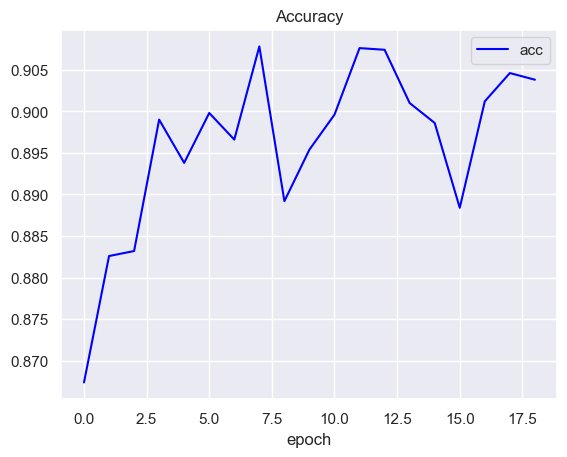

In [36]:
accuracies_plot(accuracies_RNN_concat_agg_and_last)

* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.


### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.



In [37]:
class Bidirectional_Multi_Layer_GRU_Language_Model(Basic_RNN_Language_Model):
    
    def __init__(self,
                 hidden_dim: int,          # скрытая размерность
                 vocab_size: int,          # Размер словаря
                 num_classes: int = 4,     # Кол-во классов для предсказания
                 num_rnn_layers: int = 3,  # Кол-во рекуррентных слоев модели. 
                 p_dropout: float=0.1,     # Вероятность обнуления для каждого элемента входного тензора слоя nn.Dropout
                 aggregation_type: str = 'max'): # Тип агрегации скрытых слоёв
        
        super().__init__(
            hidden_dim,
            vocab_size,
            num_classes,
            num_rnn_layers,
            p_dropout,
            aggregation_type
        )

        #self.hidden_dim = hidden_dim

        # Линейный слой().
        self.linear = nn.Linear(2 * hidden_dim, hidden_dim)

        # Рекуррентный двунаправленный блок.
        # На входе вектор слова (входная скрытая размерность), на выходе скрытый слой (выходная скрытая размерность), 
        # а так же кол-во рекуррентных слоев модели. 
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=num_rnn_layers, batch_first=True, bidirectional=True)


            # Получаем входной батч.
    def forward(self, input_batch) -> torch.Tensor:
        # Эмбединги для входного батча
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        # output = (output[:, :, self.hidden_dim:]
        #           + output[:, :, :self.hidden_dim]) / 2  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction



In [38]:
model_bidirectional_GRU_multi_layer = Bidirectional_Multi_Layer_GRU_Language_Model(
                                                                                hidden_dim=512, 
                                                                                vocab_size=len(vocab), 
                                                                                num_classes = 4,
                                                                                num_rnn_layers = 3, 
                                                                                aggregation_type='max').to(device)

criterion_bidirectional_GRU_multi_layer = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer_bidirectional_GRU_multi_layer = torch.optim.Adam(model_bidirectional_GRU_multi_layer.parameters())

In [39]:
epochs = 10

losses_bidirectional_GRU_multi_layer, accuracies_bidirectional_GRU_multi_layer = train( model = model_bidirectional_GRU_multi_layer,       # Модель
                                                            criterion = criterion_bidirectional_GRU_multi_layer,     # Функция потерь
                                                            optimizer = optimizer_bidirectional_GRU_multi_layer, # оптимизатор 
                                                            num_epochs = epochs,          # Кол-во эпох
                                                            train_loader = train_dataloader, # Тренировочные данные
                                                            val_loader = eval_dataloader    # Валидационные данные
                                                            )

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

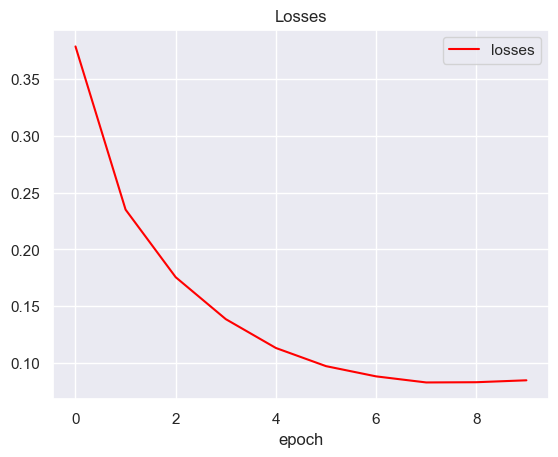

In [40]:
losses_plot(losses_bidirectional_GRU_multi_layer)

Лучшая accuracy для подхода: 90.84


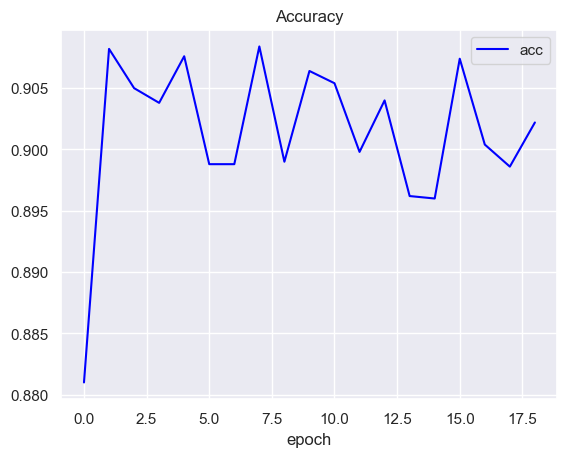

In [41]:
accuracies_plot(accuracies_bidirectional_GRU_multi_layer)

# Лучшая accuracy для подхода: 91.56

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

## Общие условия для всех экспериментов следующие: 
##### тип агрегации скрытых слоёв для каждого эксперимента 'max'
##### hidden_dim = 512
##### dropout = 0.1
##### количество эпох 10

### Мной были проведены следующие эксперименты:

- Классификация текста на базе nn.RNN() блока.
      Лучшая accuracy для подхода: 90.52
  
- Классификация текста на базе nn.GRU() блока.
        Лучшая accuracy для подхода: 91.26

- Классификация текста на базе nn.LSTM() блока.
        Лучшая accuracy для подхода: 91.18

- Классификация текста на базе из 5 слоёв nn.GRU() блоков.
        Лучшая accuracy для подхода: 91.20

- Классификация текста на базе конкатенированого вектора последнего токена nn.RNN() блока с вектором агрегации всех токенов nn.RNN() блока.
        Лучшая accuracy для подхода: 90.78

- Классификация текста на базе двунаправленной 5 слойной nn.GRU().
        Лучшая accuracy для подхода: 91.56


### Вывод:
 
- Стабильную сходимость, а так же высокую accuracy показала модель на базе из 5 слоёв nn.GRU() блоков. Её же я бы назвал оптимальной.

- В остальных экспериментах мне не удалось добиться стабильной сходимости. Вероятно надо подобрать более оптимальные гиперпараметры (dropout_rate, hidden_dim, кол-во эпох, ...).

- Лучшую accuracy = 91.56 показала двунаправленная 5 слойная nn.GRU().